# July 2023 Cu-B DARK

dTHF + LiBF4 + dEtOH



In [1]:
import sys
import os
import json

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

from matplotlib.path import Path
from matplotlib.patches import PathPatch

#%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib

sys.path.append(os.path.expanduser('~/git/analysis_playground/bayesian-fitting'))
sys.path.append(os.path.expanduser('~/git/nh3-analysis'))
import summary_plots
try:
    from bumps import dream
    import fit_uncertainties
    importlib.reload(fit_uncertainties)
    HAS_BUMPS  = True
except:
    print("No bumps")
    HAS_BUMPS = False



In [2]:
data_dir = os.path.expanduser('/SNS/REF_L/IPTS-30384/shared/dynamic/Cu-B')

# Auto-reduction directory
ar_dir = '/SNS/REF_L/IPTS-30384/shared/autoreduce/'

dyn_data_dir = '/SNS/REF_L/IPTS-30384/shared/dynamic/Cu-B/30s'

fit_dir = os.path.expanduser('~/reflectivity_fits/IPTS-30384')
dyn_fit_dir = os.path.expanduser('~5oo/reflectivity_fits')

delta_t = 30

In [3]:

def plot_dyn_data(file_list, initial_state, final_state, delta_t=30,
                  fit_dir=None, ar_dir=None, dyn_data_dir=None, dyn_fit_dir=None, model_name='__model', scale=1):
    # Reduced data
    pre_data_file = os.path.join(ar_dir, 'REFL_%s_combined_data_auto.txt' % initial_state)
    pre_data = np.loadtxt(pre_data_file).T

    post_data = None
    if final_state is not None:
        post_data_file = os.path.join(ar_dir, 'REFL_%s_combined_data_auto.txt' % final_state)
        post_data = np.loadtxt(post_data_file).T

    # Fit results
    pre_fit = None
    pre_fit_file = os.path.join(fit_dir, str(initial_state), "__model-refl.dat")
    if os.path.isfile(pre_fit_file):
        pre_fit = np.loadtxt(pre_fit_file).T

    post_fit = None
    post_fit_file = os.path.join(fit_dir, str(final_state), "__model-refl.dat")
    if os.path.isfile(post_fit_file):
        post_fit = np.loadtxt(post_fit_file).T

    # Dynamic data
    fig, ax = plt.subplots(dpi=100, figsize=(5,8))
    plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)

    #plt.plot(pre_data[0], pre_data[1], linewidth=1, color='darkgreen', label='initial')
    idx = pre_data[2]<pre_data[1]
    plt.errorbar(pre_data[0][idx], pre_data[1][idx], yerr=pre_data[2][idx], linewidth=1, 
                 markersize=2, marker='.', linestyle='',
                 color='darkgreen', label='Pre cycle 1')

    if pre_fit is not None:
        plt.plot(pre_fit[0], pre_fit[4], linewidth=1, markersize=2, marker='', color='black', zorder=400)

    scale = 10.
    multiplier = 10
    for _file in file_list:
        scale *= 1
        _label = '%d < t < %d s' % (_file[0], _file[0]+delta_t)

        # Get fit if it exists
        fit_file = os.path.join(dyn_fit_dir, _file[1], '%s-refl.dat' % model_name)

        if os.path.isfile(fit_file):
            fit_data = np.loadtxt(fit_file).T
            plt.plot(fit_data[0], fit_data[4]*scale, markersize=2, marker='', linewidth=1, color='black')


            idx = fit_data[3]<fit_data[2]
            plt.errorbar(fit_data[0][idx], fit_data[2][idx]*scale,
                         yerr=fit_data[3][idx]*scale, linewidth=1,
                         markersize=2, marker='.',  linestyle='', label=_label)

            scale *= multiplier

    final_scale = scale

    if post_fit is not None:
        plt.plot(post_fit[0], post_fit[4]*final_scale, linewidth=1, color='darkblue')#, label='final')
    if post_data is not None:
        idx = post_data[2]<post_data[1]
        plt.errorbar(post_data[0][idx], post_data[1][idx]*final_scale, yerr=post_data[2][idx]*final_scale, linewidth=1, 
                     markersize=2, marker='.', linestyle='',
                     color='darkgreen', label='Post cycle 1')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 7})
    plt.xlabel('Q ($1/\AA$)', fontsize=15)
    plt.ylabel('Reflectivity', fontsize=15)
    plt.yscale('log')
    plt.xscale('log')
    ax.yaxis.labelpad = 1

    plt.show()
    return file_list

def plot_dyn_sld(file_list, initial_state, final_state, delta_t=30,
                 fit_dir=None, dyn_data_dir=None, dyn_fit_dir=None, model_name='__model',
                 model_file=None, legend_font_size=6):

    fig, ax = plt.subplots(dpi=250, figsize=(5, 4.1))
    plt.subplots_adjust(left=0.15, right=.95, top=0.95, bottom=0.15)

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # Plot initial state
    i_color = 0
    if initial_state is not None:
        i_color = 1
        plot_sld(initial_state, 'Initial state', fit_dir=fit_dir)  

    for _file in file_list:
        i_color += 1
        i_color = i_color % len(colors)
        profile_file = os.path.join(dyn_fit_dir, str(_file[1]), '%s-profile.dat' % model_name)
        if not os.path.isfile(profile_file):
            print("Could not find: %s" % profile_file)
            continue
        _data = np.loadtxt(profile_file).T
   
        _label = '%d < t < %d s' % (int(_file[0]), int(_file[0])+delta_t)
        plt.plot(_data[0][-1]-_data[0], _data[1], markersize=4, color=colors[i_color],
                 label=_label, linewidth=1, )

    # Plot final OCP
    if final_state is not None:
        plot_sld(final_state, 'Final state', fit_dir=fit_dir)           
        
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(frameon=False, prop={'size': 10})
    plt.legend(handles[::-1], labels[::-1], loc='lower right', frameon=False, fontsize=legend_font_size)
    plt.xlabel('z ($\AA$)', fontsize=14)
    plt.ylabel('SLD ($10^{-6}/\AA^2$)', fontsize=14)
    plt.show()

def plot_sld(run, title, fit_dir=None, dq=0.027, z_offset=0.0):
    """
        :param ar_dir: Automated-reduction directory
    """
    sld_file = os.path.join(fit_dir, str(run), "__model-profile.dat")
    print(sld_file)
    if not os.path.isfile(sld_file):
        print("Could not find %s" % sld_file)
        return
    pre_sld = np.loadtxt(sld_file).T
    plt.plot(pre_sld[0][-1]-pre_sld[0]+z_offset, pre_sld[1], markersize=4, label=title, linewidth=2, )

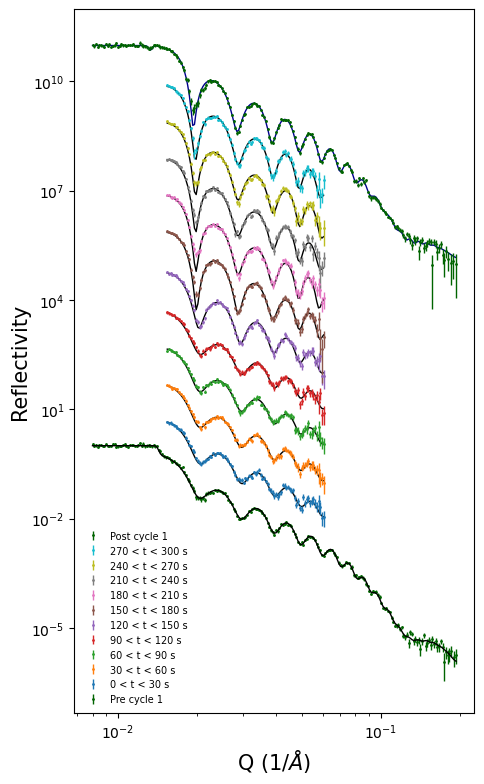

[[0, '2604965', '2604965'],
 [30, '2604966', '2604966'],
 [60, '2604967', '2604967'],
 [90, '2604968', '2604968'],
 [120, '2604969', '2604969'],
 [150, '2604970', '2604970'],
 [180, '2604971', '2604971'],
 [210, '2604972', '2604972'],
 [240, '2604973', '2604973'],
 [270, '2604974', '2604974']]

In [4]:
dyn_fit_dir = os.path.expanduser('~5oo/reflectivity_fits')

file_list = [[0, '2604965', '2604965'],
             [30, '2604966', '2604966'],
             [60, '2604967', '2604967'],
             [90, '2604968', '2604968'],
             [120, '2604969', '2604969'],
             [150, '2604970', '2604970'],
             [180, '2604971', '2604971'],
             [210, '2604972', '2604972'],
             [240, '2604973', '2604973'],
             [270, '2604974', '2604974'],
            ]

plot_dyn_data(file_list, 207012, 207020,
              fit_dir=fit_dir, ar_dir=ar_dir, dyn_data_dir=dyn_data_dir, dyn_fit_dir=dyn_fit_dir)

/SNS/users/m2d/reflectivity_fits/IPTS-30384/207012/__model-profile.dat
/SNS/users/m2d/reflectivity_fits/IPTS-30384/207020/__model-profile.dat


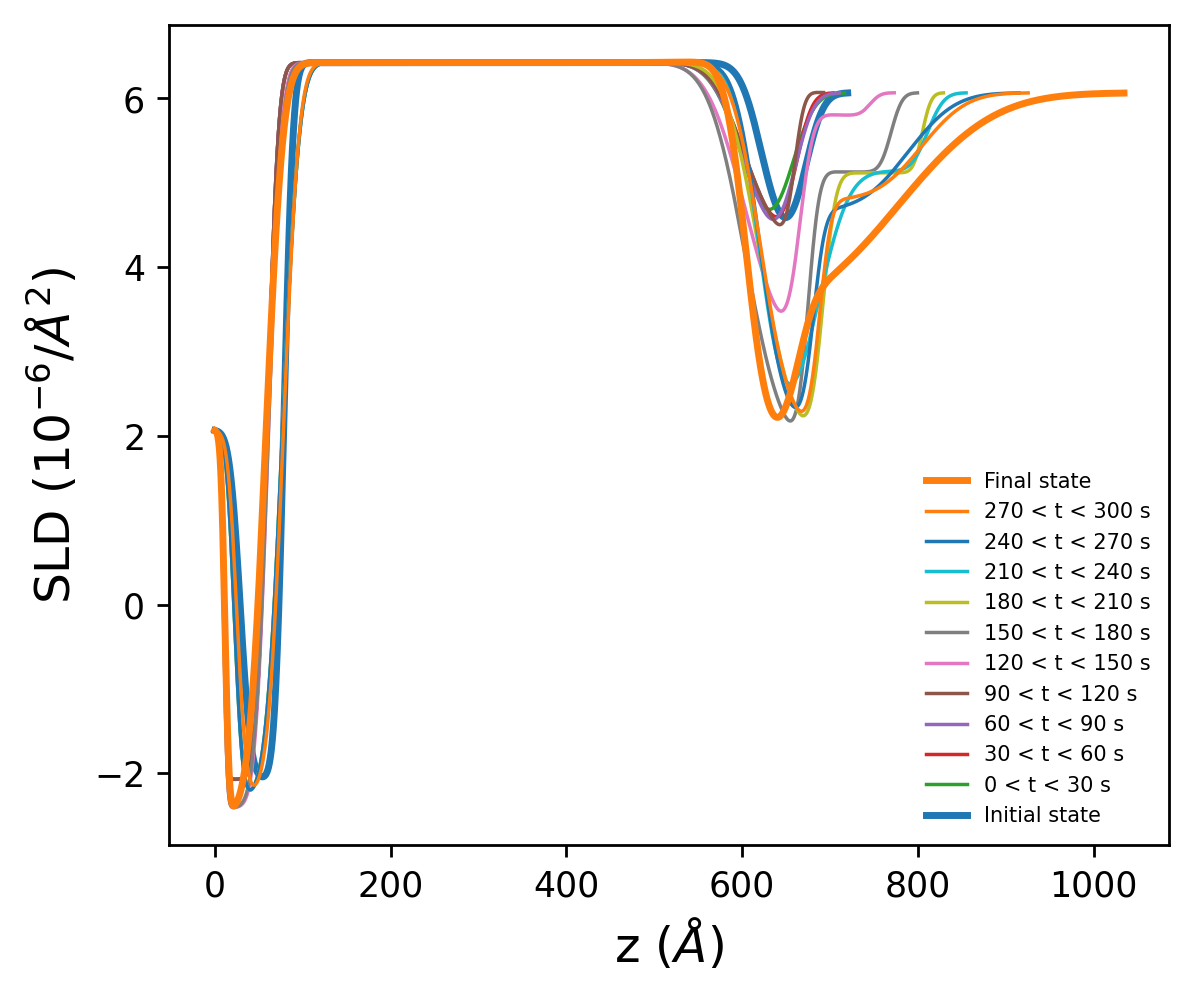

In [5]:
plot_dyn_sld(file_list, 207012, 207020,
              fit_dir=fit_dir, dyn_data_dir=dyn_data_dir, dyn_fit_dir=dyn_fit_dir)

/SNS/users/m2d/reflectivity_fits/IPTS-30384/207020/__model-profile.dat
Processing: /SNS/users/5oo/reflectivity_fits/2604974/__model.py
Read in /SNS/users/5oo/reflectivity_fits/2604974/__model.py
Model: /SNS/users/5oo/reflectivity_fits/2604974/__model
Z offset = -121.055;    Z_max = 925.6
Too many points: pruning down
MC file read: 0.0010294914245605469 sec
Done 10.581361293792725 sec
Processing: /SNS/users/5oo/reflectivity_fits/2604973/__model.py
Read in /SNS/users/5oo/reflectivity_fits/2604973/__model.py
Model: /SNS/users/5oo/reflectivity_fits/2604973/__model
Z offset = -126.014;    Z_max = 915.3
Too many points: pruning down
MC file read: 0.0016813278198242188 sec
Done 5.404417276382446 sec
Processing: /SNS/users/5oo/reflectivity_fits/2604972/__model.py
Read in /SNS/users/5oo/reflectivity_fits/2604972/__model.py
Model: /SNS/users/5oo/reflectivity_fits/2604972/__model
Z offset = -43.6656;    Z_max = 855
Too many points: pruning down
MC file read: 0.0010914802551269531 sec
Done 4.95591

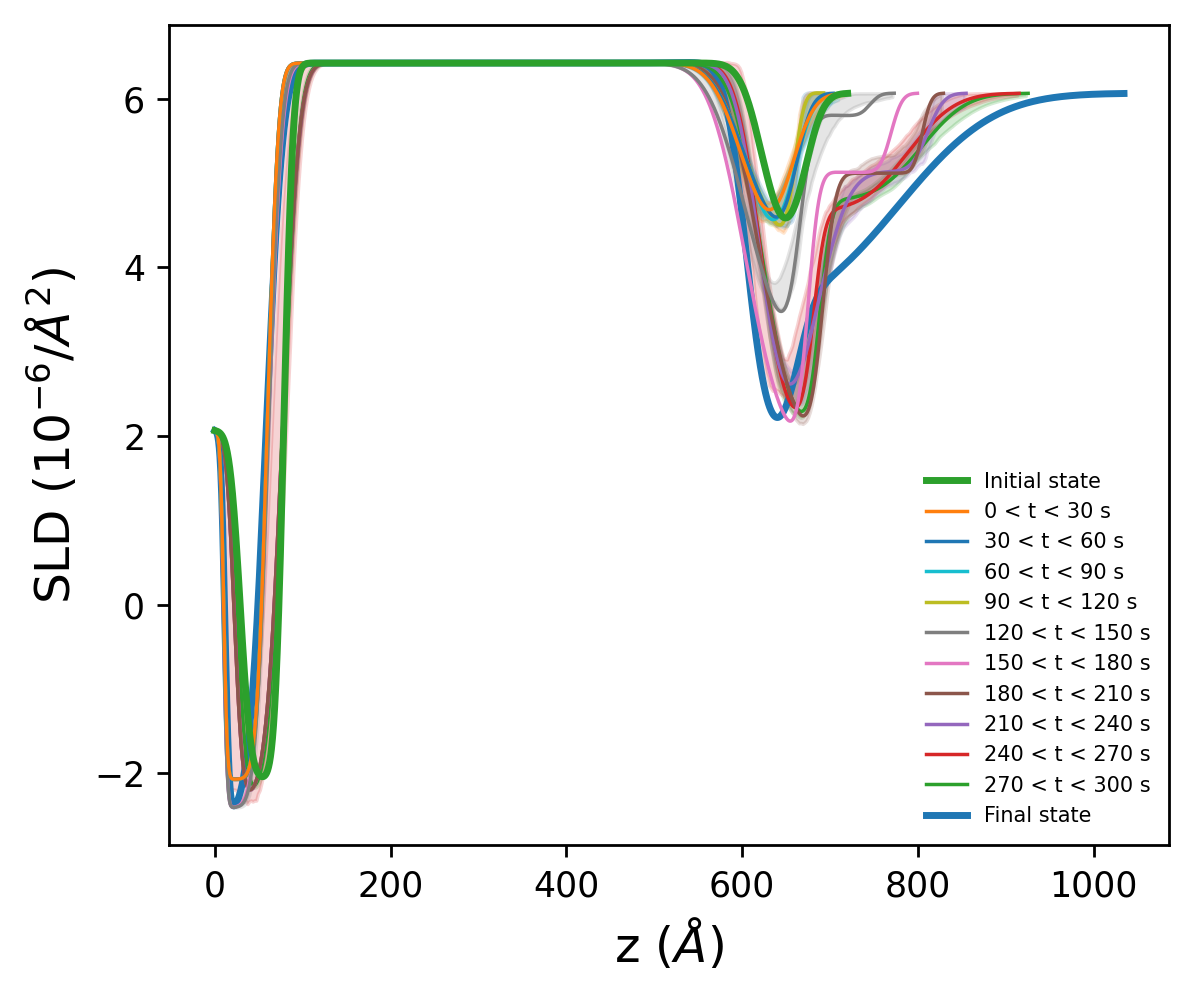

In [6]:
importlib.reload(summary_plots)

summary_plots.plot_dyn_sld(file_list, 207012, 207020, 
                           fit_dir=fit_dir, dyn_data_dir=dyn_data_dir, dyn_fit_dir=dyn_fit_dir, delta_t=30, 
                           show_cl=True, model_file=None, model_name='__model')

THF interface 16.05
Cu interface 8.24
Ti interface 9.59
Ti rho -2.07
Ti thickness 49.81
Could not write file
THF interface [16.05, 85.6]
Cu interface [8.24, 15.3]
Ti interface [9.59, 3.8]
Ti rho [-2.07, -2.48]
Ti thickness [49.81, 46.6]
SEI interface [15.8]
SEI rho [3.4]
SEI thickness [114.5]


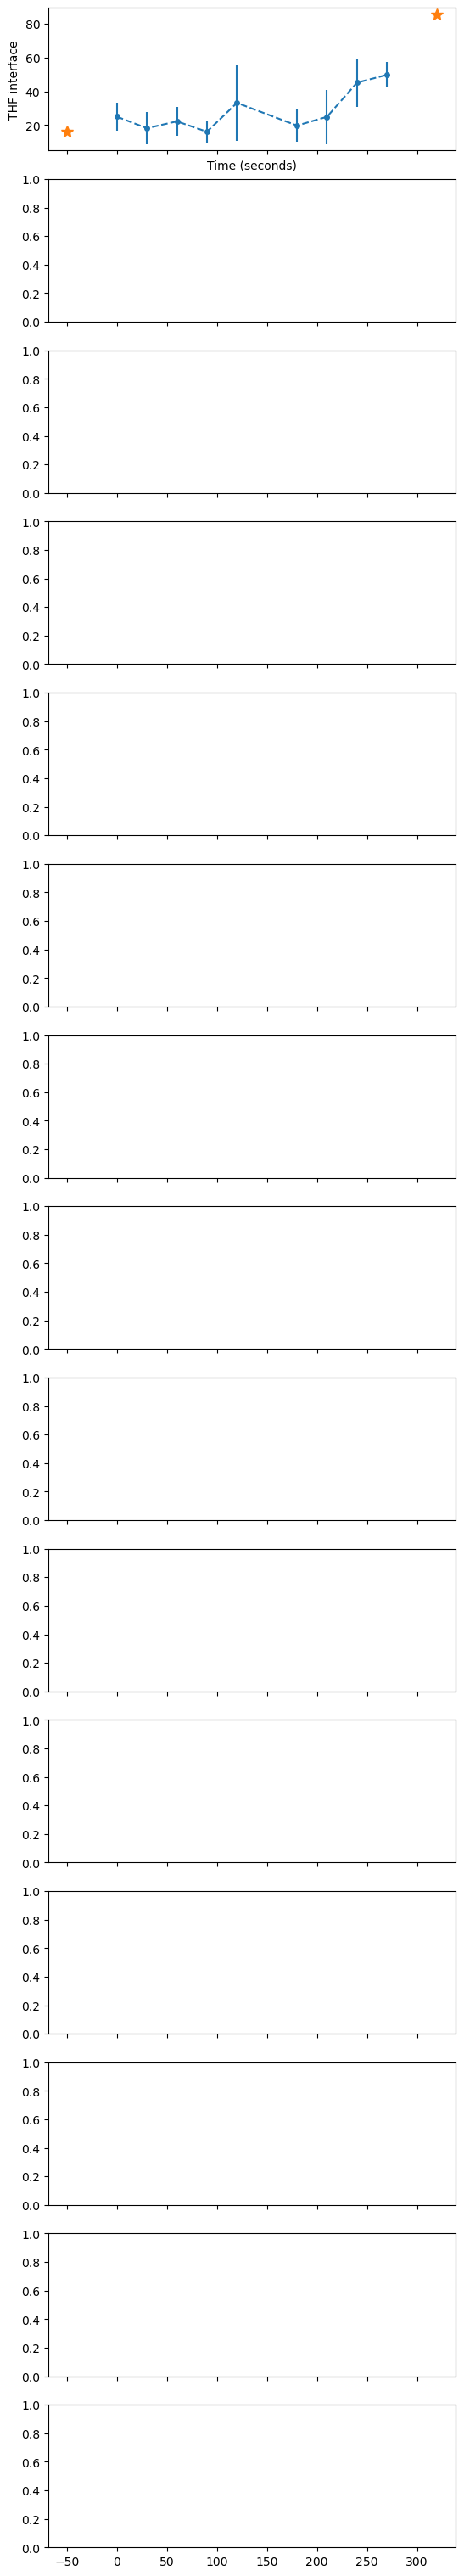

In [7]:
importlib.reload(summary_plots)

timestamps, trend_data, trend_err = summary_plots.trend_data(file_list, 207012, 207020, 
                                                   fit_dir=fit_dir, dyn_data_dir=dyn_data_dir, dyn_fit_dir=dyn_fit_dir, 
                                                   model_name='__model', model_file=None, add_plot=0)


dict_keys(['THF interface', 'oxi interface', 'oxi rho', 'oxi thickness', 'Cu interface', 'CuOx interface', 'CuOx rho', 'CuOx thickness', 'SEI interface', 'SEI rho', 'SEI thickness', 'Ti rho', 'Ti thickness', 'Ti interface'])


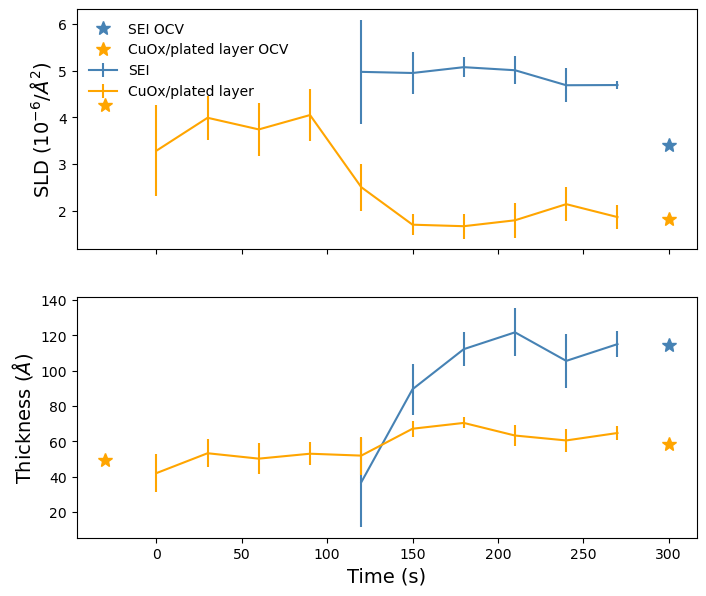

In [23]:
material_rho = [4.27, 1.82]
material_thickness = [49.7, 58.7]
sei_rho = [3.4]
sei_thickness = [114.5]

print(trend_data.keys())

i_start = len(trend_data['oxi rho'])

fig, axs = plt.subplots(2, 1, dpi=100, figsize=(8,7), sharex=True)
plt.subplot(2, 1, 1)

if not len(trend_data['CuOx rho']) == len(timestamps):
    for i in range(i_start):
        trend_data['CuOx rho'].insert(i, trend_data['oxi rho'][i])
        trend_err['CuOx rho'].insert(i, trend_err['oxi rho'][i])
        trend_data['CuOx thickness'].insert(i, trend_data['oxi thickness'][i])
        trend_err['CuOx thickness'].insert(i, trend_err['oxi thickness'][i])


plt.errorbar(timestamps[i_start:], trend_data['SEI rho'], yerr=trend_err['SEI rho'], label='SEI', color='steelblue')

plt.errorbar(timestamps, trend_data['CuOx rho'], yerr=trend_err['CuOx rho'], label='CuOx/plated layer', color='orange')
plt.plot([timestamps[-1]+30], sei_rho, linestyle='', marker='*', color='steelblue', markersize=10, label='SEI OCV')
plt.plot([timestamps[0]-30, timestamps[-1]+30], material_rho, linestyle='', marker='*', color='orange', markersize=10, label='CuOx/plated layer OCV')

#plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('SLD ($10^{-6}/\AA^2$)', fontsize=14)
plt.legend(frameon=False)



plt.subplot(2, 1, 2)
plt.errorbar(timestamps[i_start:], trend_data['SEI thickness'], yerr=trend_err['SEI thickness'], color='steelblue')
plt.errorbar(timestamps, trend_data['CuOx thickness'], yerr=trend_err['CuOx thickness'], color='orange')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Thickness ($\AA$)', fontsize=14)

plt.plot([timestamps[-1]+30], sei_thickness, linestyle='', marker='*', color='steelblue', markersize=10, label='SEI OCV')
plt.plot([timestamps[0]-30, timestamps[-1]+30], material_thickness, linestyle='', marker='*', color='orange', markersize=10, label='Oxide/plated OCV')
